In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
import zipfile
with zipfile.ZipFile('/content/AffectNetHQ.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [3]:
# # Define transformations for the dataset
# image_size=(224,224)
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                           std=[0.5, 0.5, 0.5]),
# ])

# transform_test = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                           std=[0.5, 0.5, 0.5]),
# ])


# Define transformations for the dataset
image_size=(224,224)
transform_train = transforms.Compose([
     transforms.ToTensor()
])

transform_test = transforms.Compose([
     transforms.ToTensor()
])

In [4]:
# Define the data loaders
# Load the dataset
train_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/validation', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/test', transform=transform_test)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True, drop_last=False,num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)

In [5]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

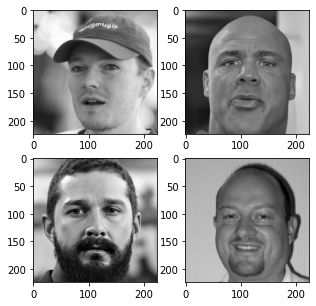

In [6]:
plot_data_loader(train_loader, (2, 2))

In [7]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 8


In [8]:
train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Train Size: 6400
Test Size: 2000
Validation Size: 1600


In [9]:
torch.cuda.empty_cache()

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


Device: cuda:0


In [11]:
# Define the function for training the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

# Define the function for validating the model
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
val_losses = []
val_accs = []
# Train and validate the model for 30 epochs
num_epochs = 30
for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # Validate the model
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    
    # Print the results
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    # Step the learning rate scheduler
    lr_sched.step()
    # Show progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/30 | Train Loss: 1.7473 | Train Acc: 0.2900 | Val Loss: 1.6819 | Val Acc: 0.3294


Epoch 1/30: 100%|██████████| 50/50 [00:18<00:00,  2.75batch/s]


Epoch 2/30 | Train Loss: 1.7008 | Train Acc: 0.3025 | Val Loss: 1.6457 | Val Acc: 0.3192


Epoch 2/30: 100%|██████████| 50/50 [00:18<00:00,  2.76batch/s]


Epoch 3/30 | Train Loss: 1.6444 | Train Acc: 0.3222 | Val Loss: 1.5133 | Val Acc: 0.3844


Epoch 3/30: 100%|██████████| 50/50 [00:18<00:00,  2.70batch/s]


Epoch 4/30 | Train Loss: 1.4614 | Train Acc: 0.4097 | Val Loss: 1.3733 | Val Acc: 0.4567


Epoch 4/30: 100%|██████████| 50/50 [00:18<00:00,  2.72batch/s]


Epoch 5/30 | Train Loss: 1.3448 | Train Acc: 0.4705 | Val Loss: 1.3080 | Val Acc: 0.4880


Epoch 5/30: 100%|██████████| 50/50 [00:18<00:00,  2.64batch/s]


Epoch 6/30 | Train Loss: 1.2901 | Train Acc: 0.4920 | Val Loss: 1.2122 | Val Acc: 0.5291


Epoch 6/30: 100%|██████████| 50/50 [00:19<00:00,  2.61batch/s]


Epoch 7/30 | Train Loss: 1.2141 | Train Acc: 0.5230 | Val Loss: 1.2381 | Val Acc: 0.5228


Epoch 7/30: 100%|██████████| 50/50 [00:18<00:00,  2.67batch/s]


Epoch 8/30 | Train Loss: 1.0612 | Train Acc: 0.5945 | Val Loss: 1.0322 | Val Acc: 0.6150


Epoch 8/30: 100%|██████████| 50/50 [00:18<00:00,  2.67batch/s]


Epoch 9/30 | Train Loss: 1.0243 | Train Acc: 0.6123 | Val Loss: 0.9896 | Val Acc: 0.6309


Epoch 9/30: 100%|██████████| 50/50 [00:18<00:00,  2.70batch/s]


Epoch 10/30 | Train Loss: 0.9814 | Train Acc: 0.6359 | Val Loss: 0.9521 | Val Acc: 0.6473


Epoch 10/30: 100%|██████████| 50/50 [00:18<00:00,  2.70batch/s]


Epoch 11/30 | Train Loss: 0.9353 | Train Acc: 0.6531 | Val Loss: 0.8932 | Val Acc: 0.6664


Epoch 11/30: 100%|██████████| 50/50 [00:18<00:00,  2.70batch/s]


Epoch 12/30 | Train Loss: 0.8871 | Train Acc: 0.6741 | Val Loss: 0.8456 | Val Acc: 0.6959


Epoch 12/30: 100%|██████████| 50/50 [00:18<00:00,  2.65batch/s]


Epoch 13/30 | Train Loss: 0.8298 | Train Acc: 0.6987 | Val Loss: 0.7817 | Val Acc: 0.7255


Epoch 13/30: 100%|██████████| 50/50 [00:18<00:00,  2.63batch/s]


Epoch 14/30 | Train Loss: 0.7653 | Train Acc: 0.7300 | Val Loss: 0.7092 | Val Acc: 0.7538


Epoch 14/30: 100%|██████████| 50/50 [00:18<00:00,  2.71batch/s]


Epoch 15/30 | Train Loss: 0.7065 | Train Acc: 0.7552 | Val Loss: 0.6862 | Val Acc: 0.7655


Epoch 15/30: 100%|██████████| 50/50 [00:18<00:00,  2.74batch/s]


Epoch 16/30 | Train Loss: 0.6909 | Train Acc: 0.7641 | Val Loss: 0.6735 | Val Acc: 0.7719


Epoch 16/30: 100%|██████████| 50/50 [00:18<00:00,  2.72batch/s]


Epoch 17/30 | Train Loss: 0.6845 | Train Acc: 0.7675 | Val Loss: 0.6639 | Val Acc: 0.7772


Epoch 17/30: 100%|██████████| 50/50 [00:18<00:00,  2.72batch/s]


Epoch 18/30 | Train Loss: 0.6698 | Train Acc: 0.7733 | Val Loss: 0.6521 | Val Acc: 0.7809


Epoch 18/30: 100%|██████████| 50/50 [00:18<00:00,  2.65batch/s]


Epoch 19/30 | Train Loss: 0.6623 | Train Acc: 0.7766 | Val Loss: 0.6411 | Val Acc: 0.7845


Epoch 19/30: 100%|██████████| 50/50 [00:18<00:00,  2.75batch/s]


Epoch 20/30 | Train Loss: 0.6502 | Train Acc: 0.7795 | Val Loss: 0.6302 | Val Acc: 0.7906


Epoch 20/30: 100%|██████████| 50/50 [00:18<00:00,  2.77batch/s]


Epoch 21/30 | Train Loss: 0.6391 | Train Acc: 0.7830 | Val Loss: 0.6204 | Val Acc: 0.7927


Epoch 21/30: 100%|██████████| 50/50 [00:18<00:00,  2.75batch/s]


Epoch 22/30 | Train Loss: 0.6281 | Train Acc: 0.7906 | Val Loss: 0.6165 | Val Acc: 0.7964


Epoch 22/30: 100%|██████████| 50/50 [00:18<00:00,  2.65batch/s]


Epoch 23/30 | Train Loss: 0.6286 | Train Acc: 0.7903 | Val Loss: 0.6154 | Val Acc: 0.7956


Epoch 23/30: 100%|██████████| 50/50 [00:19<00:00,  2.60batch/s]


Epoch 24/30 | Train Loss: 0.6283 | Train Acc: 0.7883 | Val Loss: 0.6156 | Val Acc: 0.7959


Epoch 24/30: 100%|██████████| 50/50 [00:19<00:00,  2.60batch/s]


Epoch 25/30 | Train Loss: 0.6277 | Train Acc: 0.7902 | Val Loss: 0.6144 | Val Acc: 0.7945


Epoch 25/30: 100%|██████████| 50/50 [00:18<00:00,  2.67batch/s]


Epoch 26/30 | Train Loss: 0.6269 | Train Acc: 0.7886 | Val Loss: 0.6129 | Val Acc: 0.7966


Epoch 26/30: 100%|██████████| 50/50 [00:18<00:00,  2.69batch/s]


Epoch 27/30 | Train Loss: 0.6240 | Train Acc: 0.7914 | Val Loss: 0.6121 | Val Acc: 0.7983


Epoch 27/30: 100%|██████████| 50/50 [00:18<00:00,  2.73batch/s]


Epoch 28/30 | Train Loss: 0.6260 | Train Acc: 0.7870 | Val Loss: 0.6101 | Val Acc: 0.7972


Epoch 28/30: 100%|██████████| 50/50 [00:18<00:00,  2.73batch/s]


Epoch 29/30 | Train Loss: 0.6235 | Train Acc: 0.7927 | Val Loss: 0.6104 | Val Acc: 0.7988


Epoch 29/30: 100%|██████████| 50/50 [00:18<00:00,  2.69batch/s]


Epoch 30/30 | Train Loss: 0.6268 | Train Acc: 0.7858 | Val Loss: 0.6108 | Val Acc: 0.7989


Epoch 30/30: 100%|██████████| 50/50 [00:19<00:00,  2.63batch/s]


In [12]:
val_accs = torch.tensor(val_accs)
train_accs=torch.tensor(train_accs)

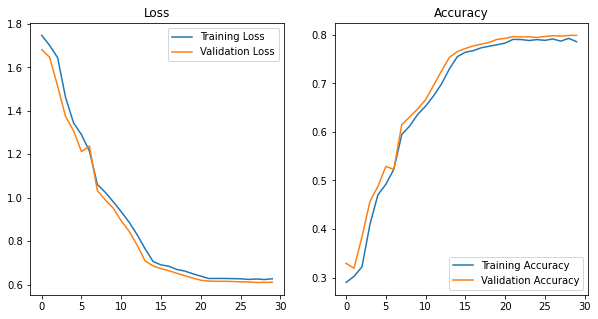

In [13]:
train_accs = [acc.item() for acc in train_accs]
val_accs = torch.tensor(val_accs)  # ensure val_accs is a PyTorch tensor
test_accs = [acc.item() for acc in val_accs]

# plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  # convert to numpy array
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Accuracy of the model on the 2000 test images: 52.800000000000004 %


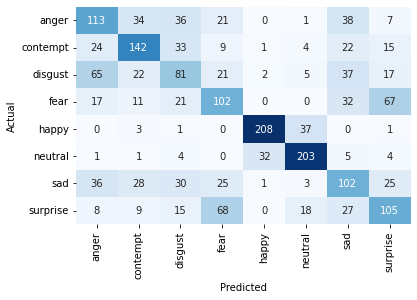

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


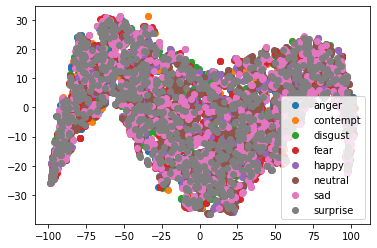

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define the label names and associated colors
label_names = ['anger', 'contempt', 'disgust','fear','happy','neutral','sad','surprise']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Load the ResNet18 model with pretrained weights
resnet18 = models.resnet18(pretrained=False)

# Remove the last layer (softmax classifier) of the model
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

# Set the model to evaluation mode
resnet18.eval()

# Extract features from the convolutional layers of the model for all images in the train dataset
features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        # Pass the images through the model to extract features
        outputs = resnet18(images)
        # Flatten the features to a 2D array
        features.append(outputs.view(outputs.size(0), -1).numpy())
        # Save the corresponding labels
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE to reduce the dimensionality of the features to 2D
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

# Plot the t-SNE graph with a legend
for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()

